<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# NIRSpec BOTS Pipeline Notebook

**Authors**: Nikolay Nikolov (AURA Associate Scientist, nnikolov@stsci.edu); NIRSpec branch</br>
**Last Updated**: November 6, 2024 </br>
**Pipeline Version**: 1.16.0 (Build 11.1rc1, Context jwst_1298.pmap)

**Purpose**: End-to-end calibration with the James Webb Space Telescope (JWST) pipeline is divided into three main processing stages. This notebook provides a framework for processing generic Near-Infrared Spectrograph (NIRSpec) fixed slit (FS) data through [stages 1-3 of the JWST pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing#gsc.tab=0), including how to use associations for multi-exposure observations and how to interact and work with JWST datamodels. Data is assumed to be organized into three folders: science and associations, as specified in the paths set up below. In most cases, editing cells outside the [Configuration](#1.-Configuration) section is unnecessary unless the standard pipeline processing options or plot parameters need to be modified.

**[Data](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))**:  This notebook is set up to use transit observations of WASP-39b with the G395H grism, obtained by Proposal ID (PID) 1366, Observation 3. The demo data will automatically download unless disabled (i.e., to use local files instead).

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**: This notebook was written for the above-specified pipeline version and associated build context from the JWST Calibration Reference Data System (CRDS). Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and associated CRDS context, taking advantage of bug fixes and algorithm improvements.**
However, if you use a different pipeline version or CRDS context, please read the relevant release notes ([here for the pipeline](https://github.com/spacetelescope/jwst), [here for CRDS](https://jwst-crds.stsci.edu/)) for possibly relevant changes. Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-bots-known-issues#gsc.tab=0) for this build are noted in the notebook. 

**Updates**: This notebook is regularly updated to incorporate the latest pipeline improvements. Find the most up-to-date version of this notebook [here](https://github.com/spacetelescope/jwst-pipeline-notebooks/). 

**Recent Changes**:</br>
* October 15, 2024: Converted notebook to follow standard template ([original](https://github.com/exonik/JWST-NIRSpec-STScI-pipeline-rerun/blob/main/BOTS_pipeline_rerun.ipynb)). </br>
* November 6, 2024: Notebook updated to JWST pipeline version 1.16.0 (Build 11.1rc1).

---

## Table of Contents

* [1. Configuration](#1.-Configuration)
* [2. Package Imports](#2.-Package-Imports)
* [3. Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
* [4. Directory Setup](#4.-Directory-Setup)
* [5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)](#5.-Stage-1:-Detector1Pipeline-(calwebb_detector1))
    * [5.1 Configure `Detector1Pipeline`](#5.1-Configure-Detector1Pipeline)
    * [5.2 Run `Detector1Pipeline`](#5.2-Run-Detector1Pipeline)
    * [5.3 Display `Detector1Pipeline` Products](#5.3-Display-Detector1Pipeline-Products)
* [6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)](#5.-Stage-2:-Spec2Pipeline-(calwebb_spec2))
    * [6.1 Configure `Spec2Pipeline`](#6.1-Configure-Spec2Pipeline)
    * [6.2 Create `Spec2Pipeline` ASN Files](#6.2-Create-Spec2Pipeline-ASN-Files)
    * [6.3 Run `Spec2Pipeline`](#6.3-Run-Spec2Pipeline)
    * [6.4 Display `Spec2Pipeline` Products](#6.4-Display-Spec2Pipeline-Products)
* [7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)](#5.-Stage-3:-Spec3Pipeline-(calwebb_spec3))
    * [7.1 Configure `Spec3Pipeline`](#7.1-Configure-Spec3Pipeline)
    * [7.2 Create `Spec3Pipeline` ASN Files](#7.2-Create-Spec3Pipeline-ASN-Files)
    * [7.3 Run `Spec3Pipeline`](#7.3-Run-Spec3Pipeline)
    * [7.4 Display `Spec3Pipeline` Products](#7.4-Display-Spec3Pipeline-Products)
* [8. Modifying the EXTRACT1D Reference File (as needed)](#8.-Modifying-the-EXTRACT1D-Reference-File-(as-needed))

---

## 1. Configuration

Set the basic parameters to configure the notebook. These parameters determine what data gets used and where the data is located (if already on disk). The list of parameters includes:

* `demo_mode`:
    * `True`: Downloads example data from the [Barbara A. Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) and processes it through the pipeline. All processing will occur in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.
    * `False`: Process your own downloaded data; provide its location.
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.
    * `asn_dir`: Directory where stage 2/3 association files are stored.

In [1]:
# Basic import necessary for configuration.

import os
import warnings
import logging

# Control logging level: INFO, WARNING, ERROR
# Hide RuntimeWarning messages?
logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

<div class="alert alert-block alert-warning">
    
Note that `demo_mode` must be set appropriately below.
</div>

In [2]:
# Set parameters for demo_mode, data mode directories, and processing steps.

# -------------------------------DEMO MODE-----------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# ----------------------------User Mode Directories--------------------------
else:  # If demo_mode = False, look for user data in these paths.

    # Set directory paths for processing specific data; adjust to your local
    # directory setup (examples provided below).
    basedir = os.path.join(os.getcwd(), '')

    # Directory to science observation data; expects uncalibrated data in
    # sci_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    sci_dir = os.path.join(basedir, 'fs_data_02288/Obs002', '')

    # Directory to stage 2/3 association files.
    asn_dir = os.path.join(basedir, 'fs_data_02288/asn', '')

Running in demonstration mode using online example data!


---

### Set CRDS Context and Server

Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline. If the local CRDS cache directory has not been set, it will automatically be created in the home directory.

[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [3]:
# ------------------------Set CRDS context and paths------------------------
os.environ['CRDS_CONTEXT'] = 'jwst_1298.pmap'  # CRDS context for 1.16.0

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS Context:', os.environ['CRDS_CONTEXT'])
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS Context: jwst_1298.pmap
CRDS local filepath: /Users/kglidic/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


---

## 2. Package Imports


In [4]:
# Use the entire available screen width for this notebook.
from IPython.display import display, HTML, JSON
display(HTML("<style>.container { width:95% !important; }</style>"))

In [51]:
# ----------------------General Imports----------------------
import time
import glob
import json
import requests
import itertools
import numpy as np

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.table import Table
from astropy.stats import sigma_clip
from astroquery.mast import Observations
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found here: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) • 
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) • 
[Github](https://github.com/spacetelescope/jwst)

</div> 

In [6]:
# ----------------------JWST Calibration Pipeline Imports----------------------
import jwst  # Import the base JWST and CRDS packages.
from crds.client import api
from stpipe import crds_client

# JWST pipelines (each encompassing many steps).
from jwst.pipeline import Detector1Pipeline  # calwebb_detector1
from jwst.pipeline import Spec2Pipeline  # calwebb_spec2
from jwst.pipeline import Tso3Pipeline  # calwebb_tso3
from jwst.extract_1d import Extract1dStep  # Extract1D Step
from jwst import datamodels  # JWST pipeline utilities: datamodels.

print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))

JWST Calibration Pipeline Version = 1.16.0


---

### Define Convience Functions

In [7]:
def get_jwst_file(name,
                  mast_api_token=None,
                  save_dir=".",
                  redownload=False):
    """
    Retrieve a JWST data file from MAST archive and save it to a specified directory.

    Parameters
    ----------
    name : str
        File name.
    mast_api_token : str
        MAST authorization token. Get your MAST Token Here: https://auth.mast.stsci.edu/token.
    save_dir : str
        Save directory path.
    redownload : bool
        Redownload the data even if it exsits already?

    Returns
    -------
    file_path : str
        Path to newly saved file.
    """
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    headers = {"Authorization": f"token {mast_api_token}"} if mast_api_token else {}
    file_path = os.path.join(save_dir, name)

    # Check if the file already exists in the save directory.
    if os.path.exists(file_path) and not redownload:
        print(f"The file {name} already exists in the directory. Skipping download.")
        return file_path

    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()

    with open(file_path, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

    return file_path

In [8]:
def update_asn_paths(asn_files,
                     exclude_dirs=[]):
    """
    Update the expname field in an ASN file with its absolute path.

    The absolute path is determined by locating matching files in the
    current directory while excluding any files found in the specified
    excluded directories. Absolute paths ensure that the pipeline correctly
    locates the files, regardless of the ASN file's location.

    Parameters
    ----------
    asn_files : list of str
        List of ASN files to update.
    exclude_dirs : list of str, optional
        List of directories to exclude in the search.

    Returns
    -------
    None.
    """

    # Ensure asn_files is a list.
    asn_files = [asn_files] if isinstance(asn_files, str) else asn_files

    for asn in asn_files:
        with open(asn, 'r') as file:
            data = json.load(file)

        update = False

        # Loop through each product and its members.
        for product in data['products']:
            for member in product['members']:
                search_pattern = f"**/{member['expname']}"
                filtered_files = [f for f in glob.glob(os.path.join(os.getcwd(),
                                  search_pattern), recursive=True) if not
                                  any(f.startswith(exc) for exc in exclude_dirs)]
                if len(filtered_files) > 0:
                    member['expname'] = filtered_files[0]
                    update = True

        basn = os.path.basename(asn)
        if update:
            try:
                with open(asn, 'w') as json_file:
                    json.dump(data, json_file, indent=4)
                print(f"{basn} 'expname' paths have been updated to absolute paths!")
            except Exception as e:
                print(f"Error saving updated file {asn}: {e}")
        else:
            print(f"{basn} 'expname' paths NOT updated! Paths may be absolute.")

In [9]:
def display_rate(rates,
                 slits_models=[],
                 integration=0,
                 extname='data',
                 cmap='viridis',
                 bad_color=(1, 0.7, 0.7),
                 vmin=None,
                 vmax=None,
                 scale='asinh',
                 aspect='auto',
                 title_prefix=None,
                 title_path=False,
                 save_plot=False):
    """
    Display countrate images.

    Parameters
    ----------
    rates : list of str
        A list of RATE[INTS] files to be displayed.
    slits_models : list of str, optional
        A list of CAL[INTS] or S2D files containing the slit models.
        If provided, slit cutouts will be overlaid on the countrate images.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
    extname : str, optional
        The name of the data extension to extract from ('data', 'dq', etc.).
    cmap : str, optional
        Colormap to use for displaying the image. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for NaN pixels. Default is light red (1, 0.7, 0.7).
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    save_plot : bool, optional
        If True, saves the plot as a PNG file. Default is False.
    """

    # -------------------------------Check Inputs-------------------------------
    rates = [rates] if isinstance(rates, str) else rates
    slits_models = [slits_models] if isinstance(slits_models, str) else slits_models
    nrates = len(rates)

    # ------------------------------Set up figures------------------------------
    fig, axes = plt.subplots(nrates, 1, figsize=(12, 12 * nrates),
                             sharex=True, height_ratios=[1] * nrates)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = [axes] if nrates == 1 else axes

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)

    # ---------------------------Plot countrate image---------------------------
    for i, (rate, cal) in enumerate(itertools.zip_longest(rates,
                                                          slits_models,
                                                          fillvalue=None)):

        # -------------------Open files as JWST datamodels-------------------
        model = datamodels.open(rate)
        slits_model = datamodels.open(cal) if cal else None

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # ----------------Plot the countrate image & colorbar---------------
        plt.subplots_adjust(left=0.05, right=0.85)
        im = axes[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')
        units = model.meta.bunit_data
        cbar_ax = fig.add_axes([axes[i].get_position().x1 + 0.02,
                                axes[i].get_position().y0, 0.02,
                                axes[i].get_position().height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(units, fontsize=12)

        # -----------------Draw slits and label source ids------------------
        # slits_model can be s2d/cal from spec2 - contains slit models for all sources.
        if slits_model:
            slit_patches = []
            for slit in slits_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart),
                                       slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                y = slit.ystart + slit.ysize / 2
                x = slit.xstart if 'nrs1' in rate else slit.xstart + slit.xsize
                ha = 'right' if 'nrs1' in rate else 'left'
                plt.text(x, y, slit.source_id, color='w', ha=ha, va='center',
                         fontsize=7, path_effects=[], weight='bold')
            axes[i].add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

        # -----------------Construct title and axis labels------------------
        filename = model.meta.filename
        title = (f"{title_prefix + ' ' if title_prefix else ''}"
                 f"{filename if title_path else os.path.basename(filename)}")
        if integration is not None:
            title = title.replace('rateints', f'rateints[{integration}]')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Pixel Column", fontsize=12)
        axes[i].set_ylabel("Pixel Row", fontsize=12)

        # -------------------------Save the figure?-------------------------
        if save_plot:
            save_plot = rate.replace('fits', 'png')
            if integration:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
            fig.savefig(save_plot, dpi=200)

        fig.show()

In [53]:
def compile_segments(data_products):
    """
    Compiles extracted 1D spectra, corresponding timestamps,
    and wavelengths from a list of X1D data products.

    Parameters
    ----------
    data_products : list of str
        A list of data products (X1DINT files).

    Returns
    -------
    all_spec_1D : numpy.ndarray
        A 2D array where each row corresponds to a spectrum from a single
        integration, and columns represent flux values at each wavelength.
    all_times : numpy.ndarray
        A 1D array containing the mid-integration times (e.g., BJD_TDB) for
        each spectrum in `all_spec_1D`.
    """

    data_products = [data_products] if isinstance(data_products, str) else data_products

    # Return empty arrays if the input list is empty.
    if not data_products:
        return None, None

    for i, product in enumerate(data_products):

        x1d = datamodels.open(product)

        n_spec = len(x1d.spec)
        n_pix = len(x1d.spec[i].spec_table.FLUX)
        seg_spec_1D = np.zeros([n_spec, n_pix])
        wave_um = x1d.spec[0].spec_table.WAVELENGTH

        for j in range(n_spec):
            seg_spec_1D[j, :] = x1d.spec[j].spec_table.FLUX

        if i == 0:
            all_spec_1D = seg_spec_1D
            all_times = x1d.int_times.int_mid_BJD_TDB
        if i > 0:
            all_spec_1D = np.concatenate((all_spec_1D, seg_spec_1D), axis=0)
            all_times = np.concatenate((all_times,
                                        x1d.int_times.int_mid_BJD_TDB),
                                       axis=0)

    # We also trim several columns at the start and end of the spectra.
    # These belong to the reference pixels and are marked 'nan'.
    print("Trimming first/last 5 reference pixels with nan-values ...")
    all_spec_1D = all_spec_1D[:, 5:-5]
    wave_um = wave_um[5:-5]

    return all_spec_1D, all_times, wave_um

In [11]:
def display_spectra(data_products,
                    integrations=0,
                    offsets=0):
    """
    Displays the calibrated BOTS spectra from Stage 2.

    Parameters
    ----------
    data_products : str or list of str
        File path or list of file paths to X1D data products.
    integrations : int or list of int, optional
        Indices of integrations to plot (default is 0).
    offset : int or list of int, optional
        Offsets to apply between spectra (default is 0).

    Returns
    -------
    None.
    """

    # -----------------------Check and sort input lists-----------------------
    data_products = [data_products] if isinstance(data_products, str) else data_products
    integrations = [integrations] if isinstance(integrations, int) else integrations
    offsets = [offsets] * len(integrations) if isinstance(offsets, (int)) else offsets

    # Sort NRS1 and NRS2 products.
    products = {
        "NRS1": [f for f in sorted(data_products) if 'nrs1' in f],
        "NRS2": [f for f in sorted(data_products) if 'nrs2' in f]
    }

    # ----------Load extracted spectra and time stamps into one array---------
    for key, product_list in products.items():
        if not product_list:
            continue

        # Load all spectra from list of segments.
        # This makes plotting and analysis easier.
        all_spec1D, all_times, wave_um = compile_segments(product_list)

        # Print summary.
        print(f"\n{key} Summary:")
        print(f"  Total number of time stamps: {len(all_spec1D)}")
        print(f"  Total number of 1D spectra:  {all_spec1D.shape[0]}")
        print(f"  Total number of columns:     {all_spec1D.shape[1]}")
        print(f"  Total length of wavemap:     {len(wave_um)}\n")

        # --------------------------Set up figures--------------------------
        fig, axes = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[1, 2])
        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        ax2d, ax1d = axes

        for idx, i in enumerate(integrations):
            ax1d.plot(wave_um, all_spec1D[i, :] - offsets[idx],
                      label=f'Spectrum {i}')

        ax1d.set_xlabel("Wavelength (microns)")
        ax1d.set_ylabel("Flux (Jy) + Constant offset")
        ax1d.grid(True)
        ax1d.legend()

        # ------------------------Plot CAL FITS file------------------------
        x1d = datamodels.open(product_list[0]).spec[0]
        # Handle both cases dynamically
        if 'x1dints_mod' in product_list[0]:
            cal = datamodels.open(product_list[0].replace('x1dints_mod', 'calints'))
        else:
            cal = datamodels.open(product_list[0].replace('x1dints', 'calints'))

        ax2d.imshow(cal.data[0], aspect='auto', vmin=np.nanpercentile(cal.data[0], 10),
                    vmax=np.nanpercentile(cal.data[0], 90))
        ystart, ystop, xstart, xstop = (x1d.extraction_ystart - 1,
                                        x1d.extraction_ystop - 1,
                                        x1d.extraction_xstart - 1,
                                        x1d.extraction_xstop - 1)
        extract_width = ystop - ystart + 1
        box = Rectangle((xstart, ystart), xstop - xstart,
                        extract_width, fc='None', ec='r',
                        lw=2)
        ax2d.add_patch(box)
        ax2d.set_title(cal.meta.filename)

    fig.show()

    # If no products were found, display a message
    if not any(products.values()):
        print("No NRS1 or NRS2 products found. Exiting.")

In [12]:
def display_light_curve(all_spec_1D,
                        all_times,
                        wave_um,
                        total_flux_cols=(120, -20),
                        correct_tilt_event=False,
                        before_transit=(0, 170),
                        tilt_event=270,
                        after_transit=(330, 460)):
    """
    Create and display white light curve.

    Parameters
    ----------
    all_spec_1D : ndarray
        2D array of spectra (integrations x columns).
    all_times : ndarray
        Array of time stamps for integrations.
    wave_um : ndarray
        Array of wavelengths corresponding to columns.
    total_flux_cols : tuple of int
        Tuple specifying the start and end column indices
        for summing flux to calculate the white light curve.
    correct_tilt_event : bool, optional
        If True, applies a correction to address tilt events
        by normalizing affected regions.
    before_transit : tuple of int, optional
        Tuple specifying the range of indices (start, end)
        defining the data before the transit.
    tilt_event : int, optional
        Index specifying the start of the tilt event for applying corrections.
    after_transit : tuple of int, optional
        Tuple specifying the range of indices (start, end)
        defining the data after the transit.

    Returns
    -------
    None.
    """

    # --------------------------Set up figures--------------------------
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[1, 2])
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    axlc, axslc = axes

    # ---------------------Obtain white light curve---------------------
    n_spec = len(all_times)  # Number of spectra (integrations).
    wlc_flux = np.zeros(n_spec)

    # Sum all flux (total flux) in a given range.
    for i in range(n_spec):
        col_start, col_end = total_flux_cols[0], total_flux_cols[1]
        wlc_flux[i] = np.nansum(all_spec_1D[i, col_start:col_end])

    # Normalize by the median flux of the first twenty points.
    wlc_flux /= np.nanmedian(wlc_flux[0:20])

    # Calculate light curve scatter from first ~100 points.
    sigma_wlc = np.sqrt(np.nanvar(wlc_flux[2:100]))
    print(f"White Light Curve scatter (ppm):  {round(sigma_wlc * 1e6, 0)}")

    # Plot white light curve
    time_axis = (all_times - np.nanmean(all_times)) * 24.0
    axlc.plot(time_axis,
              wlc_flux, color='r', marker='o', markersize=2,
              label=f"White light curve, (r.m.s.={round(sigma_wlc * 1e6, 0)} ppm)")
    wavestart = round(wave_um[col_start], 4)
    waveend = round(wave_um[col_end], 4)
    axlc.set_title(f"White Light Curve (λ = {wavestart} - {waveend} μm)", fontsize=15)
    axlc.legend(loc="lower right")
    axlc.set_xlabel("Time since mid-exposure, hr", fontsize=15)
    axlc.set_ylabel("Normalized flux", fontsize=15)

    # Add secondary x-axis for integration indices
    integration_indices = np.arange(n_spec)
    tick_positions = np.linspace(time_axis.min(),
                                 time_axis.max(),
                                 len(integration_indices))
    axlc_secondary = axlc.secondary_xaxis('top')
    axlc_secondary.set_xlabel("Integration Index", fontsize=12)
    axlc_secondary.set_xticks(tick_positions[::len(tick_positions)//10])
    axlc_secondary.set_xticklabels([f"{int(idx)}" for idx in
                                    integration_indices[::len(integration_indices)//10]])

    # -----------------Obtain spectroscopic light curve-----------------
    lc_map = np.copy(all_spec_1D)
    spec_xlen = len(lc_map[0, :])
    for j in range(spec_xlen):
        # Normalize each spectrum by the mean.
        lc_map[:, j] /= np.nanmean(lc_map[before_transit, j])
        if correct_tilt_event:
            # Correct for tilt event.
            lc_map[tilt_event:, j] /= np.nanmean(lc_map[after_transit, j])
    axslc.set_title("Spectroscopic Light Curves", fontsize=15)
    slc = axslc.imshow(
        lc_map,
        interpolation="bilinear",
        aspect="auto",
        cmap="inferno_r",
        origin="lower",
        clim=(0.977, 1.005),
    )

    axslc.set_xlabel(r"x-column, pixel", fontsize=15)
    axslc.set_ylabel("Integration ", fontsize=15)
    plt.colorbar(slc, ax=axslc, label=r"Normalized Flux")

    fig.show()

---

## 3. Demo Mode Setup (ignore if not using demo data)

<div class="alert alert-block alert-info">

To download data from [MAST JWST](https://mast.stsci.edu/search/ui/#/jwst), you may need to input an authorization token. Get your MAST token here: https://auth.mast.stsci.edu/token. </br>
Additionally, follow [`astroquery` installation procedures](https://astroquery.readthedocs.io/en/latest/index.html#) to properly run these cells.  
    
</div> 

If running in demonstration mode, set up the program information to retrieve the uncalibrated data (`_uncal.fits`) automatically from MAST using `astroquery`. MAST provides flexibility by allowing searches based on proposal ID and observation ID, rather than relying solely on filenames. More information about the JWST file naming conventions can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).

The BOTS demo data in this notebook is from the [JWST Early Release Science (ERS) program 1366](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1366) and features transit observations of WASP-39b using the G395H grism. The program setup is briefly summarized in the table below.

| Demo Target: WASP-39b |       |   | 
|:-----------:|:-------:|:---:|
| PROGRAM | 01366 |  Program number | 
| OBSERVTN | 003 | Observation number | 
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-bright-object-time-series-spectroscopy#gsc.tab=0) | G395H/F290LP | λ: 2.87–5.14 μm (a high resolution, R ~ 2700) |
| SUBARRAY | SUB2048 | Subarray used (2048x32 pixels per integration, per group) | 
| NINTS | 465 |  Number of integrations in exposure  |           
| NGROUPS | 70 | Number of groups in integration  |
| DURATION | 29789.053 [s] | Total duration of one exposure |   
| READPATT | NRSRAPID | Readout pattern |  
| PATTTYPE | NONE | Primary dither pattern type |  
| NUMDTHPT | 1 |  Total number of points in pattern |                           
| SRCTYAPT | UNKNOWN | Source type selected in APT | 

> **Note:** The presence of a physical gap between detectors affects high-resolution BOTS observations because the spectra are long enough to span both NIRSpec detectors. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-bots-operations/nirspec-bots-wavelength-ranges-and-gaps#gsc.tab=0)
>

Many TSO exposures may contain a sufficiently large number of integrations (NINTS) so as to make their individual exposure products too large (in terms of file size on disk) to be able to handle conveniently. In these cases, the uncalibrated raw data for a given exposure are split into multiple “segmented” products, each of which is identified with a segment number (see segmented products). 

Information about existing and planned JWST TSO programs for transiting exoplanets, including with the NIRSpec BOTS mode, can be obtained from [TrExoLiSTS](https://www.stsci.edu/~nnikolov/TrExoLiSTS/JWST/trexolists.html) 

In [13]:
# Set up the program information for demo mode.

if demo_mode:

    print('Running in demonstration mode. '
          'Example data will be downloaded from MAST!')

    # NOTE:
    # The data in this notebook is public and does not require a token.
    # For other data sets, you may need to provide a token.
    # Observations.login(token=None)

    # --------------Program and observation information--------------
    program = "01366"
    sci_observtn = "003"
    bg_observtn = None
    filters = ["F290LP;G395H"]

    # ----------Define the base and observation directories----------
    basedir = os.path.join('.', f'bots_data_{program}')
    sci_dir = os.path.join(basedir, f'Obs{sci_observtn}')
    asn_dir = os.path.join(basedir, 'asn/')
    uncal_dir = os.path.join(sci_dir, 'uncal/')

    os.makedirs(uncal_dir, exist_ok=True)
    os.makedirs(asn_dir, exist_ok=True)

Running in demonstration mode. Example data will be downloaded from MAST!


Click on the following links to learn more about querying and downloading data: [Downloading data](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data)
• [Observations Class](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html)
• [Products Field Descriptions](https://mast.stsci.edu/api/v0/_productsfields.html)

In [14]:
# Obtain a list of observation IDs for the specified demo program.

if demo_mode:

    # --------------------SCIENCE Observation--------------------
    sci_obs_id_table = Observations.query_criteria(
        instrument_name=['NIRSPEC/SLIT'],
        provenance_name=["CALJWST"],
        obs_id=[f'*{program}*{sci_observtn}*'])

The demo dataset consists of six segments of `_uncal.fits` files, each approximately 1.42 GB in size.


In [15]:
# Convert visits into a list of uncalibrated data and ASN files.

if demo_mode:

    file_criteria = {'filters': filters, 'calib_level': [1],
                     'productSubGroupDescription': 'UNCAL'}
    asn_criteria = {'filters': filters, 'calib_level': [2, 3],
                    'productSubGroupDescription': 'ASN'}

    # Initialize lists for science, background, and ASN files.
    sci_downloads, asn_downloads = [], []

    pfilter = Observations.filter_products  # Alias for filter_products method.

    # ----------Identify uncalibrated SCIENCE files associated with each visit----------
    for exposure in sci_obs_id_table:
        sci_products = Observations.get_product_list(exposure)
        asn_downloads.extend(pfilter(sci_products, **asn_criteria)['dataURI'])

        # Filter for full-size science files (exclude smaller confirmation images).
        avg_sci_size = np.nanmean(sci_products['size'])
        sci_products = sci_products[sci_products['size'] > avg_sci_size]
        sci_downloads.extend(pfilter(sci_products, **file_criteria)['dataURI'])

    # Filter out other observations and remove duplicates.
    sci_downloads = {f for f in sci_downloads if f"jw{program}{sci_observtn}" in f}
    asn_downloads = {f for f in asn_downloads if any(f"-{p}{sci_observtn}_" in f
                                                     for p in ["o", "c?"])}

    print(f"Science files selected for downloading: {len(sci_downloads)}")
    print(f"ASN files selected for downloading: {len(asn_downloads)}")

Science files selected for downloading: 6
ASN files selected for downloading: 7


In [16]:
# Download data and place them into the appropriate directories.

if demo_mode:

    for file in sci_downloads:
        sci_manifest = Observations.download_file(file, local_path=uncal_dir)
    for file in asn_downloads:
        asn_manifest = Observations.download_file(file, local_path=asn_dir, cache=False)

<div class="alert alert-block alert-warning">

**Warning**: If this notebook is halted during this step, the downloaded file may be incomplete, and cause crashes later on!
</div>

---

## 4. Directory Setup
Set up detailed paths to input/output stages here.

In [18]:
# Define/create output subdirectories to keep data products organized.

# -----------------------------Science Directories------------------------------
uncal_dir = os.path.join(sci_dir, 'uncal/')  # Uncalibrated pipeline inputs.
det1_dir = os.path.join(sci_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_dir = os.path.join(sci_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.
tso3_dir = os.path.join(sci_dir, 'stage3/')  # calwebb_tso3 pipeline outputs.

os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(tso3_dir, exist_ok=True)

---

## 5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)

In this section, we process the data through the `calwebb_detector1` pipeline to create Stage 1 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: Raw exposure (`_uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
* **Output**: Uncalibrated countrate (slope) image in units of DN/s:
    * `_rate.fits`: A single countrate image averaged over multiple integrations (if available).
    * `_rateints.fits`: Countrate images for each integration, saved in multiple extensions.

The `Detector1Pipeline` applies basic detector-level corrections on a group-by-group basis, followed by ramp fitting for all exposure types, commonly referred to as "ramps-to-slopes" processing. 

---

### 5.1 Configure `Detector1Pipeline`

The `Detector1Pipeline` has the following steps available for NIRSpec BOTS:

> * `group_scale` : Rescales pixel values to correct for improper onboard frame averaging.
> * `dq_init` : Initializes the data quality (DQ) flags for the input data.
> * `saturation` : Flags pixels at or below the A/D floor or above the saturation threshold.
> * `superbias` : Subtracts the superbias reference file from the input data.
> * `refpix` : Use reference pixels to correct bias drifts.
> * `linearity` : Applies a correction for non-linear detector response.   
> * `dark_current` : Subtracts the dark current reference file from the input data.
> * `jump` : Performs CR/jump detection on each ramp integration within an exposure.
> * `ramp_fit` : Determines the mean count rate (counts per second) for each pixel by performing a linear fit to the input data.
> * `gain_scale` : Corrects pixel values for non-standard gain settings, primarily in NIRSpec subarray data.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

Below, we set up a dictionary that defines how the `Detector1Pipeline` should be configured for BOTS data. 

<div class="alert alert-warning">
  To override specific steps and reference files, use the examples below.
</div>


In [19]:
# Set up a dictionary to define how the Detector1 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['superbias'], det1dict['refpix'] = {}, {}
det1dict['linearity'], det1dict['dark_current'] = {}, {}
det1dict['jump'], det1dict['ramp_fit'], det1dict['gain_scale'] = {}, {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
# det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
# det1dict['superbias']['override_superbias'] = 'myfile.fits' # Bias subtraction
# det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
det1dict['linearity']['skip'] = False  # This is the default.

# Turn on multi-core processing (off by default).
# Choose what fraction of cores to use (quarter, half, or all).
det1dict['jump']['maximum_cores'] = 'quarter'
# det1dict['ramp_fit']['maximum_cores'] = 'half'

# Turn on detection of cosmic ray snowballs (on by default).
det1dict['jump']['expand_large_events'] = True
det1dict['jump']['expand_factor'] = 3  # (default 2)

<div class="alert alert-info">
    
Many exposures are affected by artifacts known as [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts#gsc.tab=0) caused by large cosmic ray events. These artifacts are particularly significant in deep exposures with long integration times, with an estimated rate of one snowball per detector (FULL FRAME) per 20 seconds. To expand the number of pixels flagged as jumps around large cosmic ray events, set `expand_large_events` to True. An `expand_factor` of 3 works well for NIRSpec observations to cover most snowballs.
</div>

<div class="alert alert-info">
    
JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. This noise manifests as faint banding along the detector's slow axis and varies from column to column. If not handled properly, the 1/f noise can introduce systematic errors and extra scatter in BOTS light curves. For more information, please visit [JWST Time-Series Observations Noise Sources](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#JWSTTimeSeriesObservationsNoiseSources-1/fnoise&gsc.tab=0).

For NIRSpec data, the primary pipeline algorithm to address 1/f noise is `nsclean` in the `Spec2Pipeline` (Rauscher 2023) and is off by default. However, we turned on in Stage 2. An additional 1/f noise-cleaning algorithm, `clean_flicker_noise`, has been implemented at the group stage in the `Detector1Pipeline`. This step is also off by default.
</div>

---

### 5.2 Run `Detector1Pipeline`

Run the science files and, if available, any background files through the `calwebb_detector1` pipeline using the `.call()` method. 

We use `.call()` instead of `.run()` to ensure that the latest default parameters from CRDS are applied ([ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html)).


In [20]:
# Final list of UNCAL files ready for Stage 1 processing.
uncal_sci = sorted(glob.glob(uncal_dir + '*uncal.fits'))

print(f"Science UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_sci))

Science UNCAL Files:
--------------------
./bots_data_01366/Obs003/uncal/jw01366003001_04101_00001-seg001_nrs1_uncal.fits
./bots_data_01366/Obs003/uncal/jw01366003001_04101_00001-seg001_nrs2_uncal.fits
./bots_data_01366/Obs003/uncal/jw01366003001_04101_00001-seg002_nrs1_uncal.fits
./bots_data_01366/Obs003/uncal/jw01366003001_04101_00001-seg002_nrs2_uncal.fits
./bots_data_01366/Obs003/uncal/jw01366003001_04101_00001-seg003_nrs1_uncal.fits
./bots_data_01366/Obs003/uncal/jw01366003001_04101_00001-seg003_nrs2_uncal.fits


In [ ]:
# Run Stage 1 pipeline using the custom det1dict dictionary.

start = time.time()

# --------------------------Science UNCAL files--------------------------
for uncal_file in sorted(glob.glob(uncal_dir + '*uncal.fits')):

    print(f"Applying Stage 1 Corrections & Calibrations to: "
          f"{os.path.basename(uncal_file)}")

    det1_result = Detector1Pipeline.call(uncal_file,
                                         save_results=True,
                                         steps=det1dict,
                                         output_dir=det1_dir)

print(f"\nRun time: {round((time.time()-start)/60.0, 1)} min")
print("Hurray ... Stage 1 has been completed!\n")

In [21]:
# Print output result details:
# det1_result.__dict__  # View entire contents.
# det1_result.meta.filename
# det1_result.data.shape

---

### 5.3 Display `Detector1Pipeline` Products

Inspect the Stage 1 slope products.

In [22]:
# Final list of RATE[INTS] files ready for Stage 2 processing.
rate_sci = sorted(glob.glob(det1_dir + '*_rateints*.fits'))
print(f"SCIENCE | RATE[INTS] Files:\n{'-'*20}\n" + "\n".join(rate_sci))

SCIENCE | RATE[INTS] Files:
--------------------
./bots_data_01366/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1_rateints.fits
./bots_data_01366/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2_rateints.fits
./bots_data_01366/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1_rateints.fits
./bots_data_01366/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2_rateints.fits
./bots_data_01366/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1_rateints.fits
./bots_data_01366/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2_rateints.fits


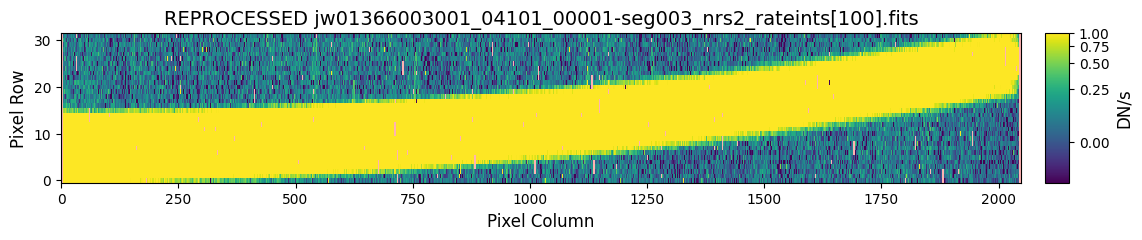

In [24]:
rate_file = rate_sci[-1]  # Show a rate file, as an example.

display_rate(rate_file, integration=100, vmin=-0.1, vmax=1, scale='asinh',
             aspect=10, title_prefix='REPROCESSED')  # , extname='dq')

---

## 6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)

In this section, we process our countrate (slope) image products from Stage 1 (`calwebb_detector1`) through the Spec2 (`calwebb_spec2`) pipeline to create Stage 2 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: A single countrate (slope) image (`_rate[ints].fits`) or an association file listing multiple inputs.
* **Output**: Calibrated products (rectified and unrectified) and 1D spectra.
	* `_cal[ints].fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
	* `_x1d[ints].fits`: Extracted 1D spectroscopic data (wavelength vs. flux).
      
The `Spec2Pipeline` applies additional instrumental corrections and calibrations (e.g., slit loss, path loss, etc.,) to countrate products that result in a fully calibrated individual exposure (per segment). The `Spec2Pipeline` also converts countrate products from units of DN/s to flux (Jy) for point sources and surface brightness (MJy/sr) for extended sources.

---

### 6.1 Configure `Spec2Pipeline`

The `Spec2Pipeline` has the following steps available for NIRSpec BOTS:

> * `assign_wcs`: Assigns wavelength solution for spectra.
> * `nsclean`: Cleans 1/f noise.
> * `extract_2d` : Extracts 2D arrays from spectral images.
> * `srctype`: Determines whether a spectroscopic source should be classified as a point or extended object.
> * `flat_field`: Applies flat-field corrections to the input science dataset.
> * `photom`: Applies photometric calibrations to convert data from countrate to surface brightness or flux density.
> * `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Below, we set up a dictionary that defines how the `Spec2Pipeline` should be configured for BOTS data. 

We opt to skip the `flat_field` and `photom` steps. as they can introduce scatter in the final light curves. This scatter arises from uncertainties in the limited number of flat field frames used to generate the flat field reference file, as well as uncertainties in the throughput used for converting the extracted spectra from relative to absolute units.


<div class="alert alert-warning">

To override specific steps and reference files, use the examples below. 

</div>

In [25]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['nsclean'] = {}, {}
spec2dict['extract_2d'], spec2dict['srctype']  = {}, {}
spec2dict['flat_field'], spec2dict['photom'] = {}, {}
spec2dict['pixel_replace'], spec2dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
# spec2dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).

# Skip this step, because it can increase the light curve scatter.
spec2dict['flat_field']['skip'] = True
spec2dict['photom']['skip'] = True   # Skip this; BOTS observations are relative.

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
spec2dict['pixel_replace']['skip'] = False
spec2dict['pixel_replace']['n_adjacent_cols'] = 5
spec2dict['pixel_replace']['algorithm'] = 'fit_profile'

# Run nsclean for 1/f noise.
spec2dict['nsclean']['skip'] = False
spec2dict['nsclean']['n_sigma'] = 0.1
spec2dict['nsclean']['save_mask'] = True
spec2dict['nsclean']['save_results'] = True
# Build a sigma-clipped mask not based on WCS.
spec2dict['nsclean']['mask_spectral_regions'] = False
spec2dict['nsclean']['save_noise'] = True  # Save the 1/f noise removed.

spec2dict['extract_1d']['apply_apcorr'] = False # Turn off aperture correction.

<div class="alert alert-info">

To correct for 1/f noise with `nsclean` in Stage 2, see the demo notebook for BOTS data [here](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/NIRSpec/NIRSpec_NSClean).

</div>

---

### 6.2 Create `Spec2Pipeline` ASN Files

[Association (ASN) files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) define the relationships between multiple exposures, allowing them to get processed as a set rather than individually. Processing an ASN file enables the exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

[Stage 2 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html) for BOTS data will typically only include `science` (not `background`) exposure types.

This notebook downloads Stage 2 ASN files directly from MAST. However, the downloaded ASN files expect the input files to be in the same directory, which is incompatible with our directory structure. In the cell below, we update the `expname` fields in the ASN files to use absolute paths to ensure the pipeline looks in the correct locations.


In [26]:
# Get list of all spec2 ASN files and categorize them.
spec2_asn_all = glob.glob(f"{asn_dir}*spec2*asn.json")
candidate_asn = [asn for asn in spec2_asn_all if "-c" in asn]
obs_asn = [asn for asn in spec2_asn_all if "-o" in asn]

# Choose ASN files: candidate if available, otherwise observation ASN.
spec2_asn = candidate_asn or obs_asn
print(f"Stage 2 ASN Files:\n{'-'*20}\n" + "\n".join(spec2_asn))

Stage 2 ASN Files:
--------------------
./bots_data_01366/asn/jw01366-o003_20240909t142802_tso-spec2_00006_asn.json
./bots_data_01366/asn/jw01366-o003_20240909t142802_tso-spec2_00001_asn.json
./bots_data_01366/asn/jw01366-o003_20240909t142802_tso-spec2_00004_asn.json
./bots_data_01366/asn/jw01366-o003_20240909t142802_tso-spec2_00002_asn.json
./bots_data_01366/asn/jw01366-o003_20240909t142802_tso-spec2_00003_asn.json
./bots_data_01366/asn/jw01366-o003_20240909t142802_tso-spec2_00005_asn.json


In [28]:
# Convert 'expname' paths in the ASN file to absolute paths.
# Ensures the pipeline can locate the files,
# regardless of the ASN file's location.
update_asn_paths(spec2_asn)

jw01366-o003_20240909t142802_tso-spec2_00006_asn.json 'expname' paths have been updated to absolute paths!
jw01366-o003_20240909t142802_tso-spec2_00001_asn.json 'expname' paths have been updated to absolute paths!
jw01366-o003_20240909t142802_tso-spec2_00004_asn.json 'expname' paths have been updated to absolute paths!
jw01366-o003_20240909t142802_tso-spec2_00002_asn.json 'expname' paths have been updated to absolute paths!
jw01366-o003_20240909t142802_tso-spec2_00003_asn.json 'expname' paths have been updated to absolute paths!
jw01366-o003_20240909t142802_tso-spec2_00005_asn.json 'expname' paths have been updated to absolute paths!


In [29]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
with open(spec2_asn[0], 'r') as f_obj:
    asnfile_data = json.load(f_obj)

JSON(asnfile_data, expanded=True)

<IPython.core.display.JSON object>

---

### 6.3 Run `Spec2Pipeline`

Run the science files through the `calwebb_spec2` pipeline using the `.call()` method.

In [30]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.

start = time.time()

# --------------------------Science ASN files--------------------------
for asn in spec2_asn:

    asn_data = json.load(open(asn))
    sci_file = os.path.basename(asn_data['products'][0]['members'][0]['expname'])
    print(f"Applying Stage 2 Corrections & Calibrations to: {sci_file}")

    spec2sci_result = Spec2Pipeline.call(asn,
                                         save_results=True,
                                         steps=spec2dict,
                                         output_dir=spec2_dir)

print(f"\nRun time: {round((time.time()-start)/60.0, 1)} min")
print("Hurray ... Stage 2 has been completed!\n")

Applying Stage 2 Corrections & Calibrations to: jw01366003001_04101_00001-seg001_nrs1_rateints.fits
Applying Stage 2 Corrections & Calibrations to: jw01366003001_04101_00001-seg003_nrs2_rateints.fits
Applying Stage 2 Corrections & Calibrations to: jw01366003001_04101_00001-seg002_nrs1_rateints.fits
Applying Stage 2 Corrections & Calibrations to: jw01366003001_04101_00001-seg003_nrs1_rateints.fits
Applying Stage 2 Corrections & Calibrations to: jw01366003001_04101_00001-seg002_nrs2_rateints.fits
Applying Stage 2 Corrections & Calibrations to: jw01366003001_04101_00001-seg001_nrs2_rateints.fits

Run time: 45.0 min
Hurray ... Stage 2 has been completed!



In [31]:
# Print output result details:
# spec2sci_result.__dict__  # View entire contents.
# spec2sci_result.meta.filename
# spec2sci_result.data.shape

---

### 6.4 Display `Spec2Pipeline` Products

Inspect the Stage 2 calibrated spectra. First, let's visually inspect that the 1/f noise was removed from the data.

In [32]:
# List the Stage 2 products.

# ------------------------1/f noise cleaned files-------------------------
masks = sorted(glob.glob(spec2_dir+'*mask.fits'))
rate_sci_cl = sorted(glob.glob(spec2_dir+'*nsclean.fits'))
flicker_noise = sorted(glob.glob(spec2_dir+'*flicker_noise.fits'))

print(f"NSCLEAN | Masks :\n{'-'*20}\n" + "\n".join(masks))
print(f"NSCLEAN | 1/F NOISE:\n{'-'*20}\n" + "\n".join(flicker_noise))
print(f"NSCLEAN | RATE:\n{'-'*20}\n" + "\n".join(rate_sci_cl))

NSCLEAN | Masks :
--------------------
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_mask.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_mask.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_mask.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_mask.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_mask.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_mask.fits
NSCLEAN | 1/F NOISE:
--------------------
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_flicker_noise.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_flicker_noise.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_flicker_noise.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_flicker_noise.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_flicker_noise

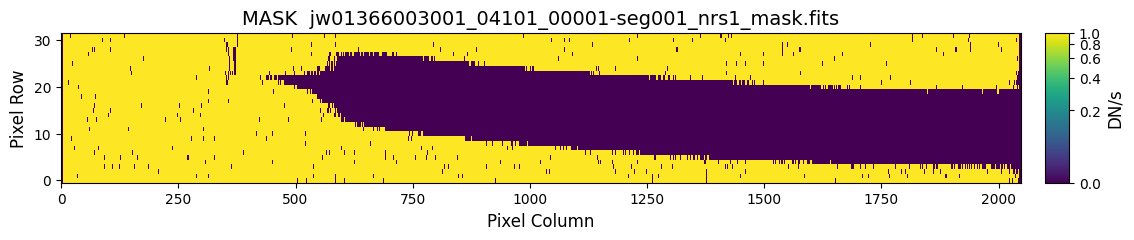

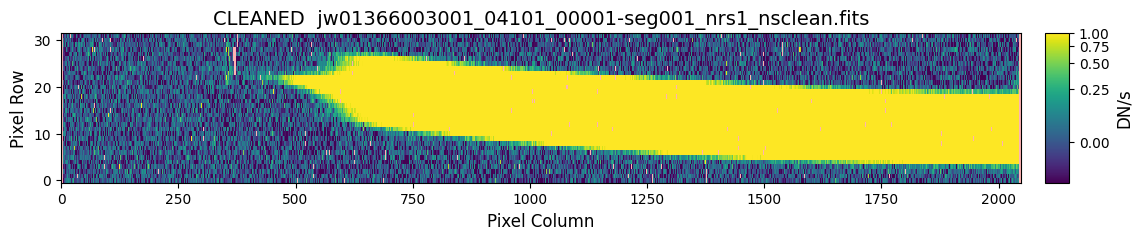

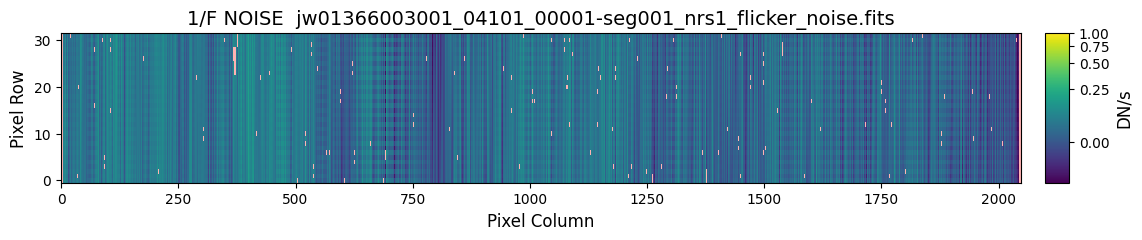

In [33]:
rate_file_cl = rate_sci_cl[0]  # Show a rate file, as an example.
noise = flicker_noise[0]
mask = masks[0]

display_rate(mask, integration=100, vmin=0, vmax=1,
             aspect=10, title_prefix='MASK ')
display_rate(rate_file_cl, integration=100, vmin=-0.1, vmax=1,
             aspect=10, scale='asinh', title_prefix='CLEANED ')
display_rate(noise, integration=100, vmin=-0.1, vmax=1,
             aspect=10, title_prefix='1/F NOISE ')

Next, we will consolidate all extracted spectra (from each segment) and their corresponding timestamps into single large arrays using the helper function `compile_spectra`. This structure simplifies the analysis and plotting.

With the consolidated arrays, we plot three one-dimensional spectra from the spectral time series using the `display_spectra` helper function. We also offset two spectra by a constant amount to make them easier to distinguish since nearly all TSO spectra have the same flux (except reduced flux during transit or secondary eclipse). 

In [34]:
# List the Stage 2 products.

# -----------------------------Science files-----------------------------
sci_cal = sorted(glob.glob(spec2_dir + '*_calints.fits'))
sci_x1d = sorted(glob.glob(spec2_dir + '*_x1dints.fits'))

print(f"SCIENCE | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(sci_cal))
print(f"SCIENCE | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(sci_x1d))

SCIENCE | Stage 2 CAL Products:
--------------------
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_calints.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_calints.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_calints.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_calints.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_calints.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_calints.fits
SCIENCE | Stage 2 X1D Products:
--------------------
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_x1dints.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_x1dints.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_x1dints.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_x1dints.fits
./bots_data_01366/Obs003/stage2/jw01366003001_04101_00001-seg003

Trimming first/last 5 reference pixels with nan-values ...

NRS1 Summary:
  Total number of time stamps: 465
  Total number of 1D spectra:  465
  Total number of columns:     1263
  Total length of wavemap:     1263

Trimming first/last 5 reference pixels with nan-values ...

NRS2 Summary:
  Total number of time stamps: 465
  Total number of 1D spectra:  465
  Total number of columns:     2038
  Total length of wavemap:     2038



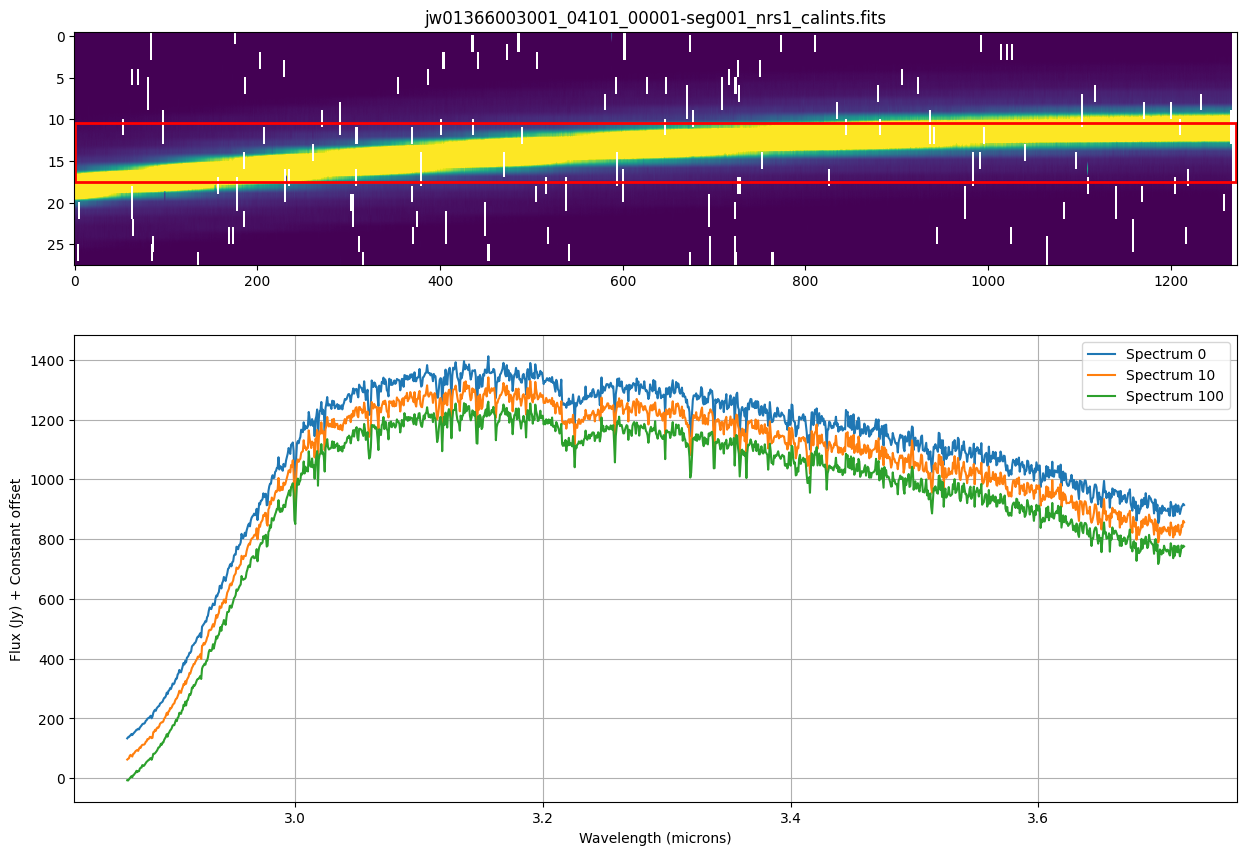

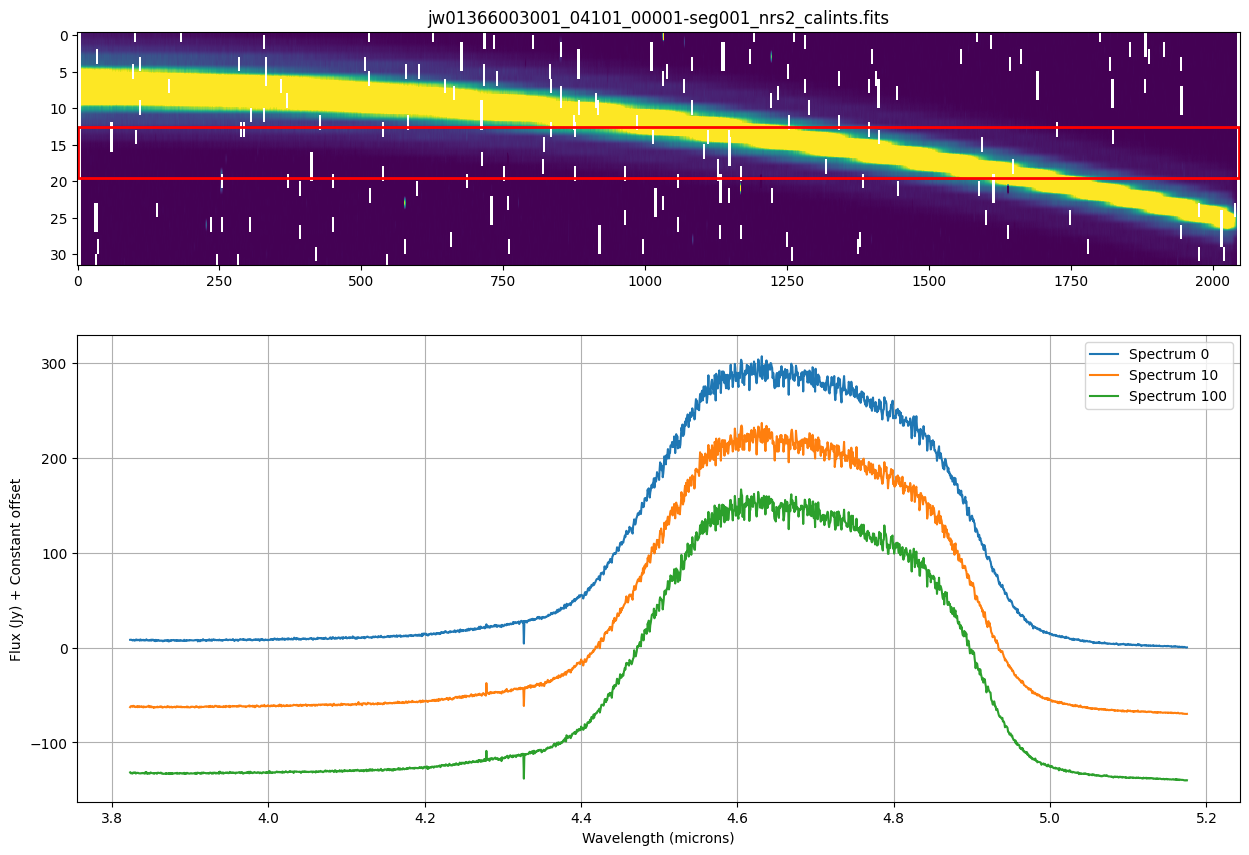

In [35]:
display_spectra(sci_x1d, integrations=[0, 10, 100], offsets=[0, 70, 140])

---

#### Modify EXTRACT1D Reference File

Notice how the default extraction region misses most of the spectrum. To address this, we modify the EXTRACT1D parameter reference file below to adjust the size of the extraction aperture. This adjustment is necessary because the pipeline currently does not resample the 2D spectra to rectify the spectra (remove the curvature). As a result, a wider extraction aperture is required.

The EXTRACT1D reference file, along with several other parameter files, can be found in the `CRDS_PATH` directory. While some files, like `.json` files, can be manually edited, we modify them using Python.

In [36]:
# Modify the EXTRACT1D reference file.

# If you don't know the reference file name this should work.
# extract_1d_ref = Spec2Pipeline().get_reference_file(sci_cal, 'extract1d')

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0006.json'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0006.json']

# Open EXTRACT1D reference file in read-mode.
with open(extract_1d_ref, "r") as ref_file:
    params = json.load(ref_file)

    # S1600A1 full slit
    params["apertures"][0]["extract_width"] = 27
    params["apertures"][0].pop("nod2_offset")  # remove
    params["apertures"][0].pop("nod3_offset")  # remove
    params["apertures"][0].pop("nod5_offset")  # remove
    # params["apertures"][0]["xstart"] = 100  # lower x-index

# Write changes to a new file.
newData = json.dumps(params, indent=4)
# Add the suffix '_bots' to distinguish the file from the default version.
basename = os.path.basename(extract_1d_ref)[:-5]
extract_1d_ref_mod = os.path.join(basedir, f'{basename}_bots.json')
with open(extract_1d_ref_mod, "w") as file:
    file.write(newData)

In [37]:
# Inspect the EXTRACT1D reference file.
with open(extract_1d_ref_mod, 'r') as f_obj:
    extract_1d_ref_mod_data = json.load(f_obj)

JSON(extract_1d_ref_mod_data, expanded=True)

<IPython.core.display.JSON object>

Now, we re-extract the 1D spectrum by running the `Extract1dStep` and overriding the reference file.


In [38]:
# Re-extract the NRS2 1D spectra.
sci_cal_nrs2 = [f for f in sci_cal if "nrs2" in f]

for cal in sci_cal_nrs2:
    Extract1dStep.call(cal,
                       save_results=True,
                       output_dir=spec2_dir,
                       output_use_model=True,
                       suffix='x1dints_mod',  # Default suffix is `_extract1dstep.fits`
                       use_source_posn=False,
                       override_extract1d=extract_1d_ref_mod)

Trimming first/last 5 reference pixels with nan-values ...

NRS2 Summary:
  Total number of time stamps: 465
  Total number of 1D spectra:  465
  Total number of columns:     2038
  Total length of wavemap:     2038



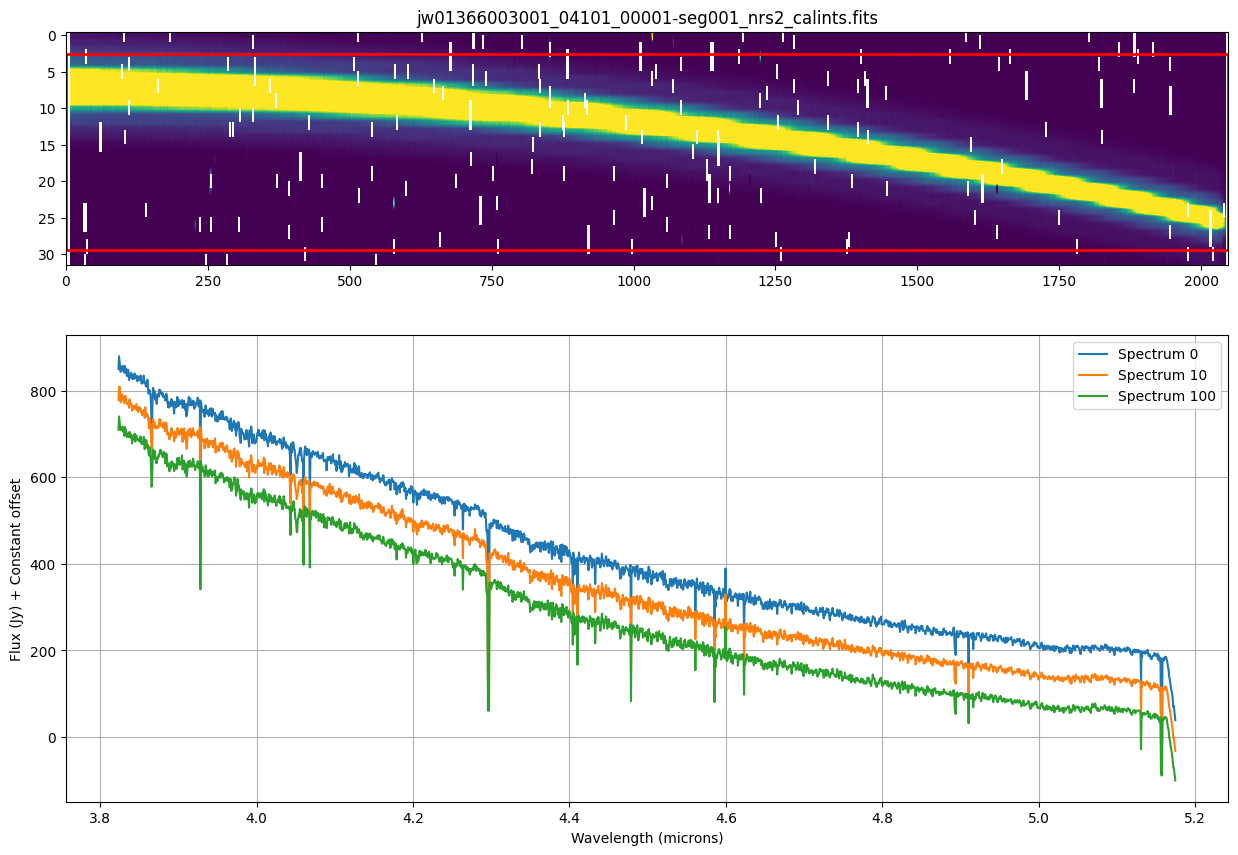

In [39]:
sci_x1d_mod = sorted(glob.glob(spec2_dir + '*nrs2_x1dints_mod.fits'))
display_spectra(sci_x1d_mod, integrations=[0, 10, 100], offsets=[0, 70, 140])

---

Next, we derive white light curves and a spectroscopic light curves from the large arrays we made and plot them.

* To produce a white light curve, we sum the flux from the full wavelength range of each extracted one-dimensional spectrum. Then we normalize the light curve by dividing the light curve flux to the median flux of the first twenty data points out-of-the-transit. We calculate and report the scatter using the first ~100 data points.

* While the white light curve provides information regarding the overall quality of the data, the light curves from each pixel (wavelength) contain information about the atmosphere of a transiting exoplanet. The second figure in the plot shows chromatic light curves (also known as wavelength maps). To produce them, we obtain a copy of all spectra and normalize each spectrum by its mean value.

    * You may find that a light curve also exhibits the morphology of a transit event along with a step-function flux jump near the mid-transit. This flux jump (a decrease of flux in this case) is attributed to a 'tilt' event associated with one of the segments of the JWST mirror. A 'tilt' event is considered any uncommanded change in the tip-tilt orientation of a mirror segment and can be caused by a micrometeorite impact. For further details, please consult the following page: [JWST TSO noise sources](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources).
        * In our plots below, we also correct for the tilt event by renormalizing the post-tilt event light curves. To do that, we divide these light curves by the mean out-of-transit post-tilt event flux. 

Trimming first/last 5 reference pixels with nan-values ...
Trimming first/last 5 reference pixels with nan-values ...
White Light Curve scatter (ppm):  239.0
White Light Curve scatter (ppm):  868.0


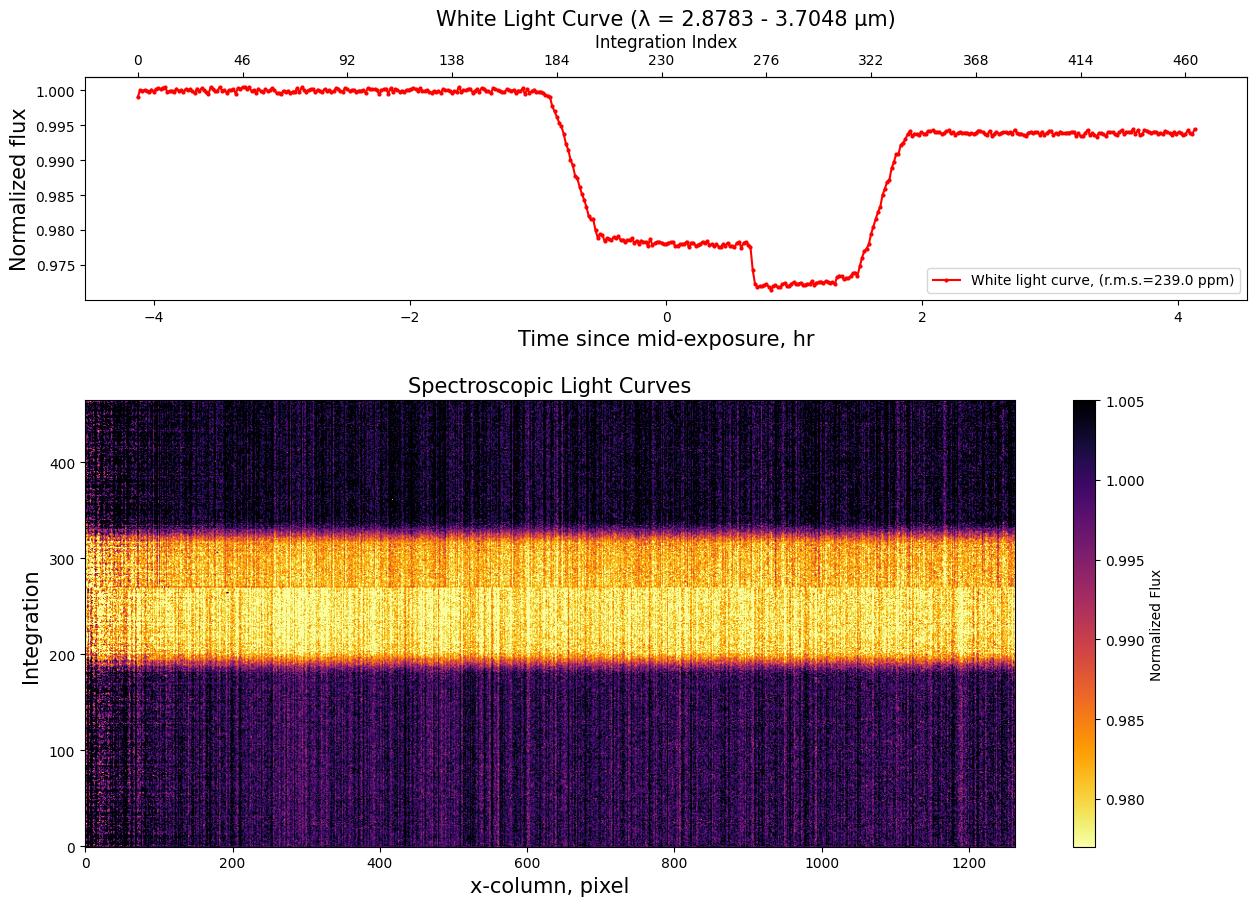

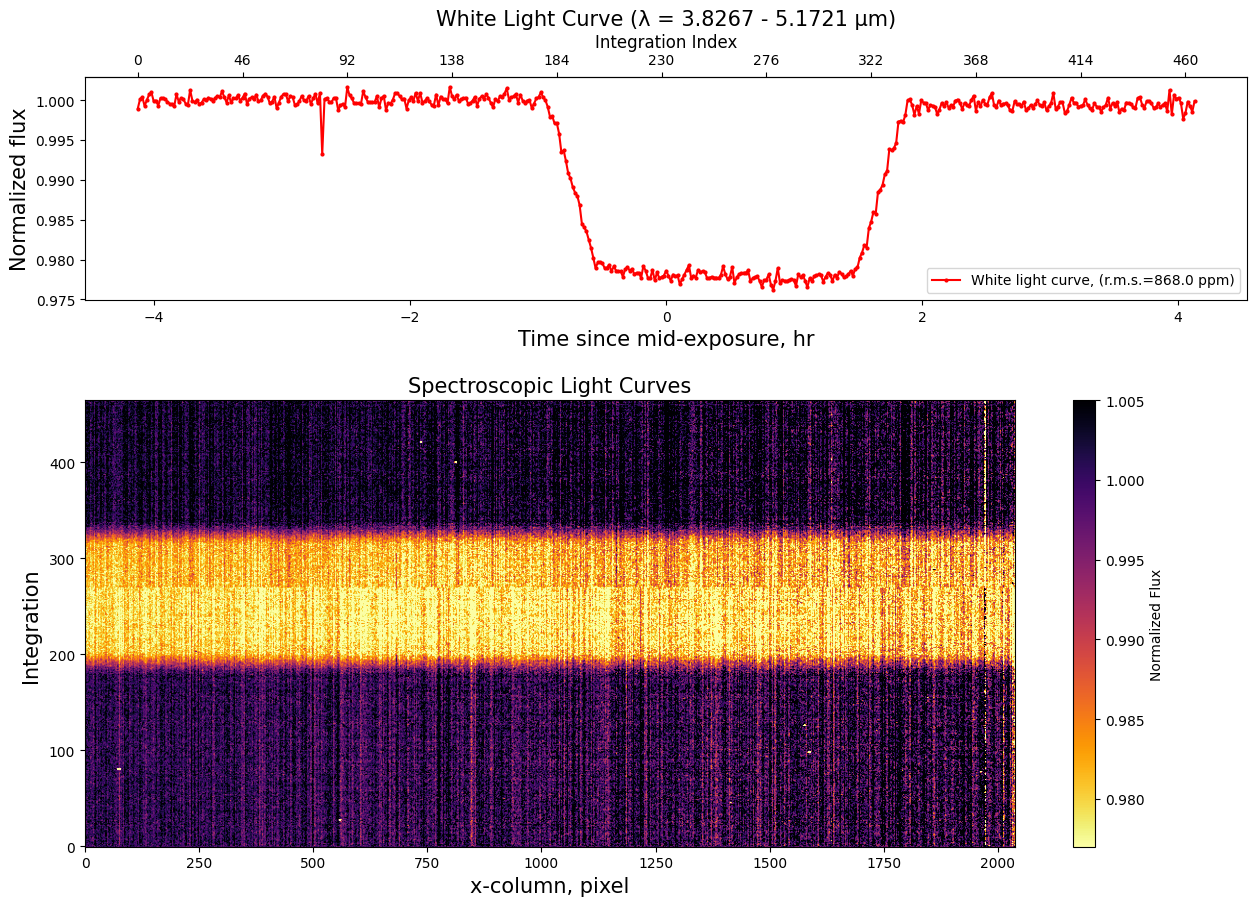

In [40]:
# Sort NRS1 from NRS2 files.
sci_x1d_nrs1 = [f for f in sci_x1d if "nrs1" in f]
sci_x1d_nrs2 = [f for f in sci_x1d_mod if "nrs2" in f]


# Compile the NRS1 and NRS2 spectra into one array.
all_spec1D_nrs1, all_times_nrs1, wave_um_nrs1 = compile_segments(sci_x1d_nrs1)
all_spec1D_nrs2, all_times_nrs2, wave_um_nrs2 = compile_segments(sci_x1d_nrs2)

# Plot the light curves for each detector.
display_light_curve(all_spec1D_nrs1, all_times_nrs1, wave_um_nrs1,
                    total_flux_cols=(20, -20), # Sum flux over integration range.
                    # Tilt event correction parameters:
                    correct_tilt_event=True,
                    before_transit=(0, 170),  # Before transit integration range.
                    tilt_event=270,  # Tilt event integration.
                    after_transit=(330, 460))  # After transit integration range.
display_light_curve(all_spec1D_nrs2, all_times_nrs2, wave_um_nrs2,
                    total_flux_cols=(5, -5), # Sum flux over integration range.
                    # Tilt event correction parameters:
                    correct_tilt_event=True,
                    before_transit=(0, 170),  # Before transit integration range.
                    tilt_event=270,  # Tilt event integration.
                    after_transit=(330, 460))  # After transit integration range.

* The white light curve shows a relatively low scatter (230 ppm) for NRS1 and a slightly higher scatter (800 ppm) for NRS2.


* The 2D plots above show all extracted 1D spectra covering the transit event. The horizontal axis is the spectral direction (wavelength), and the vertical - each integration (time). The dark pixels correspond to the out-of-transit data (pre/post transit), the orange horizontal stripes indicate the ingress and egress portions, and the yellow stripe shows the in-transit part of the light curve. We have corrected the tilt event data by normalizing all spectra after integration 330 using the post-transit flux. The cells above can be rerun without correction for the tilt event. In this case, all light curves after the tilt event will look offset by a constant amount owing to the redistributed wavefront.

<div class="alert alert-info">

We now have white and spectroscopic light curves ready for fitting (not covered in this notebook). In case there is a need to identify spectral trace and obtain centroid information for the time series, please consult the following notebook that offers workaround solutions for Spec2 with additional analysis and features, presented on a JWebbinar in December 2023: [Part2-Spec2.ipynb](https://github.com/exonik/JWebbinar2023-TSO/blob/main/Part2-Spec2.ipynb).

It should be pointed out that the workaround solutions lead to a lower white light curve scatter for this particular data set (approximately 70 ppm lower, or 160 ppm for NRS1). Two factors determine the difference:

1. The pixel replacement step in the workaround uses a nominal PSF profile constructed from adjacent columns (of a column that needs to be corrected) to identify high and low pixels in addition to the data quality flags.
2. At the time of writing, the spectral resampling step is unavailable in the STScI pipeline. Instead, in the workaround notebook, we fit for the star's centroid to locate and trace the spectra (without resampling) and perform aperture extraction using the trace.

</div>


The rest of this notebook demonstrates how to rerun the third and final stage of the STScI pipeline, which extracts the spectra (yes, again) and produces a white light curve, which we already did.

---

## 7. Stage 3: `TSO3Pipeline` (`calwebb_tso3`)

In this section, we process our calibrated spectra from Stage 2 (`calwebb_spec2`) through the Tso3 (`calwebb_tso3`) pipeline to create Stage 3 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: An ASN file that lists multiple exposures or exposure segments of a science target (`_calints.fits`).
* **Output**: Calibrated time-series spectra and white-light curve.
	* `_x1dints.fits`: Extracted 1D spectroscopic data for all integrations contained in the input exposures.
    * `_whtlt.ecsv`: An ASCII catalog in `ecsv` format containing the wavelength-integrated white-light photometry of the source.   

The `TSO3Pipeline` performs additional corrections (e.g., outlier detection) and produces calibrated time-series spectra and white-light curve of the source object.

---

### 7.1 Configure `TSO3Pipeline`

The `TSO3Pipeline` has the following steps available for NIRSpec BOTS:

> * `outlier_detection` : Identification of bad pixels or cosmic-rays that remain in each of the input images.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.
> * `white_light`: Sums the spectroscopic flux over all wavelengths in each integration of a multi-integration extracted spectrum product to produce an integrated (“white”) flux as a function of time for the target. 

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_tso3) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_tso3.html)

Below, we set up a dictionary that defines how the `TSO3Pipeline` should be configured for BOTS data. 


<div class="alert alert-warning">

To override specific steps and reference files, use the examples below. 

</div>

In [41]:
# Set up a dictionary to define how the Tso3 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
tso3dict = {}
tso3dict['outlier_detection'], tso3dict['pixel_replace'] = {}, {}
tso3dict['white_light'], tso3dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files.
# Files should be in the base local directory or provide full path.
# tso3dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
tso3dict['outlier_detection']['skip'] = True

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
tso3dict['pixel_replace']['skip'] = False
tso3dict['pixel_replace']['n_adjacent_cols'] = 5
tso3dict['pixel_replace']['algorithm'] = 'fit_profile'

<div class="alert alert-block alert-info">
    
By default, the `calwebb_tso3` pipeline will perform an `outlier_detection` and repeat spectral extraction. This workflow has been envisioned for spectral data from all JWST instruments. While the `outlier_detection` step could provide adequate corrections for non-TSO spectra, this is not the case for BOTS. We, therefore, opt to skip this step and repeat spectral extraction. It should be noted that in this case, the user can simply copy the extracted spectra from `Spec2Pipeline` and proceed with the `white_light` step instead. 
</div>

---

### 7.2 Create `Spec3Pipeline` ASN Files

[Stage 3 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_technical.html) for BOTS data will typically include multiple `science` exposures. 

This notebook downloads Stage 3 ASN files directly from MAST. However, the downloaded ASN files expect the input files to be in the same directory, which is incompatible with our directory structure. In the cell below, we update the expname fields in the ASN files to use absolute paths to ensure the pipeline looks in the correct locations.

In [42]:
# Get list of ALL spec3 ASN files.
tso3_asn = glob.glob(f"{asn_dir}*tso3*asn.json")
print(f"Stage 3 ASN Files:\n{'-'*20}\n" + "\n".join(tso3_asn))

Stage 3 ASN Files:
--------------------
./bots_data_01366/asn/jw01366-o003_20240909t142802_tso3_00001_asn.json


In [44]:
# Convert 'expname' paths in the ASN file to absolute paths.
# Ensures the pipeline can locate the files,
# regardless of the ASN file's location.
update_asn_paths(tso3_asn)

jw01366-o003_20240909t142802_tso3_00001_asn.json 'expname' paths have been updated to absolute paths!


In [45]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
with open(tso3_asn[0], 'r') as f_obj:
    asnfile_data = json.load(f_obj)

JSON(asnfile_data, expanded=True)

<IPython.core.display.JSON object>

In [46]:
# Restrict to one detector and modify the ASN file.
process_detector = "nrs1"

with open(tso3_asn[0], "r") as file:
    # read JSON data
    data = json.load(file)

# Delete file names that are not needed e.g., TA exposures.
if process_detector == "nrs1":
    del data["products"][0]["members"][7]
    del data["products"][0]["members"][6]
    del data["products"][0]["members"][5]
    del data["products"][0]["members"][3]
    del data["products"][0]["members"][1]

if process_detector == "nrs2":
    del data["products"][0]["members"][7]
    del data["products"][0]["members"][6]
    del data["products"][0]["members"][4]
    del data["products"][0]["members"][2]
    del data["products"][0]["members"][0]

# Save the modified association as a new file.
newData = json.dumps(data, indent=4)
tso3_asn_mod = tso3_asn[0][:-5] + "_" + process_detector + ".json"
with open(tso3_asn_mod, "w") as file:
    file.write(newData)

---

### 7.3 Run `Spec3Pipeline`

Run the science files through the `calwebb_tso3` pipeline using the `.call()` method.

In [47]:
# Run Stage 3 pipeline using the custom tso33dict dictionary.

start = time.time()

print(f"Applying Stage 3 to: {os.path.basename(tso3_asn_mod)}")
tso33_result = Tso3Pipeline.call(tso3_asn_mod,
                                 save_results=True,
                                 steps=tso3dict,
                                 output_dir=tso3_dir)

print(f"\nRun time: {round((time.time()-start)/60.0, 1)} min")
print("Hurray ... Stage 3 has been completed!\n")

Applying Stage 3 Corrections & Calibrations to: jw01366-o003_20240909t142802_tso3_00001_asn_nrs1.json

Run time: 5.9 min
Hurray ... Stage 3 has been completed!



In [48]:
# Print output result details:
# tso3_result.__dict__  # View entire contents.
# tso3_result.meta.filename
# tso3_result.data.shape

---

### 7.4 Display `Spec3Pipeline` Products

Inspect the Stage 3 combined calibrated spectra.

In [49]:
# List the Stage 3 products.

stage3_whtlt = sorted(glob.glob(tso3_dir + '*_whtlt.ecsv'))
stage3_x1d = sorted(glob.glob(tso3_dir + '*_x1dints.fits'))

print(f"Stage 3 White Light Products:\n{'-'*20}\n" + "\n".join(stage3_whtlt))
print(f"Stage 3 X1D Products:\n{'-'*20}\n" + "\n".join(stage3_x1d))

Stage 3 White Light Products:
--------------------
./bots_data_01366/Obs003/stage3/jw01366-o003_t001_nirspec_f290lp-g395h-sub2048_whtlt.ecsv
Stage 3 X1D Products:
--------------------
./bots_data_01366/Obs003/stage3/jw01366-o003_t001_nirspec_f290lp-g395h-sub2048_x1dints.fits


White Light Curve scatter (ppm): 238.0


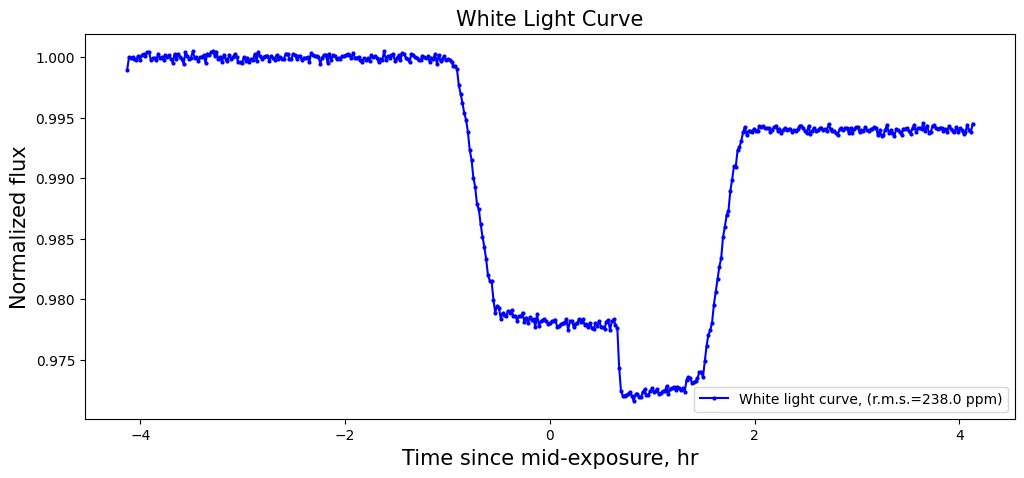

In [52]:
# Read the white light curve.
data = Table.read(stage3_whtlt[0], format="ascii.ecsv")
xx = data["MJD"]
yy = data["whitelight_flux"] / np.median(data["whitelight_flux"][:100])

# Calculate scatter.
sigma_wlc = np.sqrt(np.nanvar(yy[2:100]))
print(f"White Light Curve scatter (ppm): {round(sigma_wlc * 1e6, 0)}")

# Plot white light curve
plt.figure(figsize=(12, 5))
plt.plot(
    (xx - np.nanmean(xx)) * 24.0,
    yy,
    color="blue",
    marker="o",
    markersize=2,
    label=f"White light curve, (r.m.s.={round(sigma_wlc * 1e6, 0)} ppm)")
plt.legend(loc="lower right")
plt.title("White Light Curve", fontsize=15)
plt.xlabel("Time since mid-exposure, hr", fontsize=15)
plt.ylabel("Normalized flux", fontsize=15)

# Set plot limits
#plt.ylim([0.965, 1.015])
plt.show()


---

## Concluding Remarks

In this notebook, we demonstrated how to obtain white and spectroscopic light curves by (re-) running the three stages of the JWST pipeline. The saved data producs can now be provided to light curve fitting codes for measurements of the physical properties of the exoplanet (or other source with temporal variability) and obtaining a transmission spectrum. It should be pointed out that the analyses performed here are only a subset of the possible analyses one can perform, and are in no way the final word on _how_ JWST data _should_ be analyzed. This will be solidified more and more as data comes and best practices are established in the current and future cycles.

In conclusion, I would like to express my gratitude to the entire JWST team that has supported the creation of this notebook through discussions and testing, which have improved the notebook. In particular, special thanks to the Time-Series Observations Working Group at STScI, including Néstor Espinoza, Leonardo Ubeda, Sarah Kendrew, Elena Manjavacas, Brian Brooks, Mike Reagan, Loïc Albert, Everett Schlawin, Stephan Birkmann among others. To the NIRCam IDT team for multiple fruitful discussions, including Everett Schlawin, Thomas Beatty, Tom Greene and Jarron Leisenring. To the ERS Transiting Exoplanet team who have provided several venues for discussion and community input. To the several JWST team members, including behind the pipeline and the mission itself, including and in no particular order Bryan Hilbert, Armin Rest, Anton Koekemoer, Alicia Canipe, Melanie Clarke, James Muzerolle, Kayli Glidic, Jeff Valenti and Karl Gordon. 

---

## Related Notebooks


* [NIRSpec Workaround Notebooks](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General)
* [JDAT: JWST Data Analysis Example Notebooks](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks)

---

<figure>
       <img src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo\" align="right" style="width: 200px"/>
</figure>
   
[Top of Page](#NIRSpec-BOTS-Pipeline-Notebook)